In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm

%matplotlib inline

import torch
import torchvision

import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(device)

cuda


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform,)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'plane', 'car', 'bird'}

background_classes = {'cat', 'deer', 'dog', 'frog', 'horse','ship', 'truck'}

# print(type(foreground_classes))

dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):   #5000*batch_size = 50000 data points
    images, labels = dataiter.next()
    for j in range(batch_size):
        if(classes[labels[j]] in background_classes):
            img = images[j].tolist()
            background_data.append(img)
            background_label.append(labels[j])
        else:
            img = images[j].tolist()
            foreground_data.append(img)
            foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)

print("foreground and background created")
    
fg1, fg2, fg3 = 0,1,2  

Files already downloaded and verified
Files already downloaded and verified
foreground and background created


In [3]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
    """
        bg_idx : list of indexes of background_data[] to be used as background images in mosaic
        fg_idx : index of image to be used as foreground image from foreground data
        fg : at what position/index foreground image has to be stored out of 0-8
    """
    image_list=[]
    j=0
    for i in range(5):  # m value 
        if i != fg:
            image_list.append(background_data[bg_idx[j]])
            j+=1
        else:
            image_list.append(foreground_data[fg_idx])
            label = foreground_label[fg_idx] - fg1  # minus fg1 because our fore ground classes are fg1,fg2,fg3 but we have to store it as 0,1,2
    #image_list = np.concatenate(image_list ,axis=0)
    image_list = torch.stack(image_list) 
    return image_list,label

In [4]:
desired_num = 20000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
list_set_labels = [] 
for i in tqdm(range(desired_num)):
    set_idx = set()
    np.random.seed(i)
    bg_idx = np.random.randint(0,35000,4)
    set_idx = set(background_label[bg_idx].tolist())
    fg_idx = np.random.randint(0,15000)
    set_idx.add(foreground_label[fg_idx].item())
    fg = 0 #np.random.randint(0,5)
    fore_idx.append(fg)
    image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
    mosaic_list_of_images.append(image_list)
    mosaic_label.append(label)
    list_set_labels.append(set_idx)

100%|██████████| 20000/20000 [00:03<00:00, 5066.75it/s]


In [5]:
def create_avg_image_from_mosaic_dataset(mosaic_dataset,labels,foreground_index,dataset_number,m):
  """
  mosaic_dataset : mosaic_dataset contains 5 patches dimension 3x32x32 each as 1 data point
  labels : mosaic_dataset labels
  foreground_index : contains list of indexes where foreground image is present so that using this we can take weighted average
  dataset_number : will help us to tell what ratio of foreground image to be taken. for eg: if it is "j" then fg_image_ratio = j/m, bg_image_ratio = (m-j)/(m-1)*(m)
  """
  avg_image_dataset = []
  for i in tqdm(range(len(mosaic_dataset))):
    img = torch.zeros([3,32,32], dtype=torch.float64)
    for j in range(m):
      if j == foreground_index[i]:
        img = img + mosaic_dataset[i][j]*dataset_number/(m)
      else :
        img = img + mosaic_dataset[i][j]*(m-dataset_number)/((m-1)*(m))
    
    avg_image_dataset.append(img)
    
  return avg_image_dataset , labels , foreground_index

In [6]:
len(mosaic_list_of_images),mosaic_list_of_images[0].shape

(20000, torch.Size([5, 3, 32, 32]))

In [7]:
fore_idx

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [8]:
mosaic_list_of_images[0][0]

tensor([[[-0.1216, -0.1137,  0.0431,  ..., -0.3961, -0.4039, -0.4431],
         [ 0.2471,  0.2549,  0.2549,  ..., -0.2863, -0.4039, -0.4824],
         [ 0.1294,  0.1765,  0.1686,  ..., -0.1294, -0.2392, -0.3176],
         ...,
         [ 0.7412,  0.7255,  0.7255,  ...,  0.2078,  0.1922,  0.1294],
         [ 0.7098,  0.7412,  0.7569,  ...,  0.1608,  0.2078,  0.0980],
         [ 0.5765,  0.6471,  0.7020,  ...,  0.1608,  0.1373, -0.0745]],

        [[-0.0902, -0.0745,  0.0039,  ..., -0.2471, -0.2314, -0.2392],
         [ 0.1373,  0.1216,  0.1529,  ..., -0.1686, -0.2392, -0.2863],
         [ 0.1294,  0.1373,  0.1608,  ..., -0.0824, -0.1608, -0.2078],
         ...,
         [ 0.5373,  0.5294,  0.5137,  ...,  0.1059,  0.0745, -0.0039],
         [ 0.5451,  0.5608,  0.5529,  ...,  0.0745,  0.0902, -0.0431],
         [ 0.4118,  0.4667,  0.5294,  ...,  0.0510, -0.0118, -0.2392]],

        [[-0.6863, -0.6863, -0.6157,  ..., -0.8353, -0.8275, -0.8353],
         [-0.3804, -0.3882, -0.3569,  ..., -0

In [9]:
avg_image_dataset_1 , labels_1,  fg_index_1 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[:10000],mosaic_label[:10000],fore_idx[:10000] , 1,5)
avg_image_dataset_2 , labels_2,  fg_index_2 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[:10000],mosaic_label[:10000],fore_idx[:10000] , 2,5)
avg_image_dataset_3 , labels_3,  fg_index_3 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[:10000],mosaic_label[:10000],fore_idx[:10000] , 3,5)
avg_image_dataset_4 , labels_4,  fg_index_4 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[:10000],mosaic_label[:10000],fore_idx[:10000] , 4,5 )
avg_image_dataset_5 , labels_5,  fg_index_5 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[:10000],mosaic_label[:10000],fore_idx[:10000] , 5,5)


test_dataset_5, labels_test_5 , fg_test_index_5 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[10000:],mosaic_label[10000:],fore_idx[10000:],5,5)

100%|██████████| 10000/10000 [00:02<00:00, 4699.78it/s]


In [10]:
avg_image_dataset_5[0]

tensor([[[-0.1216, -0.1137,  0.0431,  ..., -0.3961, -0.4039, -0.4431],
         [ 0.2471,  0.2549,  0.2549,  ..., -0.2863, -0.4039, -0.4824],
         [ 0.1294,  0.1765,  0.1686,  ..., -0.1294, -0.2392, -0.3176],
         ...,
         [ 0.7412,  0.7255,  0.7255,  ...,  0.2078,  0.1922,  0.1294],
         [ 0.7098,  0.7412,  0.7569,  ...,  0.1608,  0.2078,  0.0980],
         [ 0.5765,  0.6471,  0.7020,  ...,  0.1608,  0.1373, -0.0745]],

        [[-0.0902, -0.0745,  0.0039,  ..., -0.2471, -0.2314, -0.2392],
         [ 0.1373,  0.1216,  0.1529,  ..., -0.1686, -0.2392, -0.2863],
         [ 0.1294,  0.1373,  0.1608,  ..., -0.0824, -0.1608, -0.2078],
         ...,
         [ 0.5373,  0.5294,  0.5137,  ...,  0.1059,  0.0745, -0.0039],
         [ 0.5451,  0.5608,  0.5529,  ...,  0.0745,  0.0902, -0.0431],
         [ 0.4118,  0.4667,  0.5294,  ...,  0.0510, -0.0118, -0.2392]],

        [[-0.6863, -0.6863, -0.6157,  ..., -0.8353, -0.8275, -0.8353],
         [-0.3804, -0.3882, -0.3569,  ..., -0

In [11]:
avg_image_dataset_1 = torch.stack(avg_image_dataset_1,dim=0)
avg_image_dataset_2 = torch.stack(avg_image_dataset_2,dim=0)
avg_image_dataset_3 = torch.stack(avg_image_dataset_3,dim=0)
avg_image_dataset_4 = torch.stack(avg_image_dataset_4,dim=0)
avg_image_dataset_5 = torch.stack(avg_image_dataset_5,dim=0)

test_dataset_5 = torch.stack(test_dataset_5,dim=0)

In [12]:
# alpha = 1e-4
# dirichlet_params = np.ones(500)*alpha
# dirichlet_params[0] = dirichlet_params[0]*(1)
# dirichlet_sampled_weight = np.random.dirichlet(dirichlet_params.tolist(),size =2000)
# cnt = 0 
# for i in range(len(dirichlet_sampled_weight)):
#   if np.sum(dirichlet_sampled_weight[i]>1e-2) > 1:
#     cnt +=1
# print(cnt)



In [13]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    #self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] #, self.fore_idx[idx]

In [14]:
batch = 256


# training_data = avg_image_dataset_5    #just change this and training_label to desired dataset for training
# training_label = labels_5

traindata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
trainloader_1 = DataLoader( traindata_1 , batch_size= batch ,shuffle=True)

traindata_2 = MosaicDataset(avg_image_dataset_2, labels_2 )
trainloader_2 = DataLoader( traindata_2 , batch_size= batch ,shuffle=True)

traindata_3 = MosaicDataset(avg_image_dataset_3, labels_3 )
trainloader_3 = DataLoader( traindata_3 , batch_size= batch ,shuffle=True)

traindata_4 = MosaicDataset(avg_image_dataset_4, labels_4 )
trainloader_4 = DataLoader( traindata_4 , batch_size= batch ,shuffle=True)

traindata_5 = MosaicDataset(avg_image_dataset_5, labels_5 )
trainloader_5 = DataLoader( traindata_5 , batch_size= batch ,shuffle=False)



testdata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
testloader_1 = DataLoader( testdata_1 , batch_size= batch ,shuffle=False)

testdata_2 = MosaicDataset(avg_image_dataset_2, labels_2 )
testloader_2 = DataLoader( testdata_2 , batch_size= batch ,shuffle=False)

testdata_3 = MosaicDataset(avg_image_dataset_3, labels_3 )
testloader_3 = DataLoader( testdata_3 , batch_size= batch ,shuffle=False)

testdata_4 = MosaicDataset(avg_image_dataset_4, labels_4 )
testloader_4 = DataLoader( testdata_4 , batch_size= batch ,shuffle=False)

testdata_5 = MosaicDataset(avg_image_dataset_5, labels_5 )
testloader_5 = DataLoader( testdata_5 , batch_size= batch ,shuffle=False)

testdata_6 = MosaicDataset(test_dataset_5, labels_test_5 )
testloader_6 = DataLoader( testdata_6 , batch_size= batch ,shuffle=False)


mosaicdata = MosaicDataset(mosaic_list_of_images[0:10000], mosaic_label[0:10000] )
mosaicloader = DataLoader( mosaicdata , batch_size= batch ,shuffle=False)




In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.fc4 = nn.Linear(10,3)

        torch.nn.init.xavier_normal_(self.conv1.weight)
        torch.nn.init.zeros_(self.conv1.bias)
        torch.nn.init.xavier_normal_(self.conv2.weight)
        torch.nn.init.zeros_(self.conv2.bias)
        torch.nn.init.xavier_normal_(self.fc1.weight)
        torch.nn.init.zeros_(self.fc1.bias)
        torch.nn.init.xavier_normal_(self.fc2.weight)
        torch.nn.init.zeros_(self.fc2.bias)
        torch.nn.init.xavier_normal_(self.fc3.weight)
        torch.nn.init.zeros_(self.fc3.bias)
        torch.nn.init.xavier_normal_(self.fc4.weight)
        torch.nn.init.zeros_(self.fc4.bias)

    def forward(self, z):
        #batch = z.size(0)
        #patches = z.size(1)
        #z = z.view(batch*patches,3,32,32)
        y1 = self.pool(F.relu(self.conv1(z)))
        y1 = self.pool(F.relu(self.conv2(y1)))
        y1 = y1.view(-1, 16 * 5 * 5)

        y1 = F.relu(self.fc1(y1))
        y1 = F.relu(self.fc2(y1))
        y1 = F.relu(self.fc3(y1))
        y1 = self.fc4(y1)
        return y1 

In [16]:
def calculate_loss_alpha(mosaic_loader,alpha_,net,loss_criterion):
    m = 5
    
    loss = []
    with torch.no_grad():
        for i,data in enumerate(mosaic_loader):
            inputs,target =data

            inputs = inputs.to(device)
            target = target.to(device)

            batch = inputs.size(0)
            #print(batch)
            patches = inputs.size(1)
            #dims = inputs.size(2)
            
            
            data_weight = torch.ones((batch,patches,3,32,32))*((1-alpha_)/(m-1))
            
            
            data_weight[:,0,:] = torch.ones((batch,3,32,32))*alpha_
            
            

            #print(data_weight[0])
            
            data_weight = data_weight.to(device)
            
            data = torch.mul(data_weight,inputs)
            
            data_new = torch.zeros((batch,3,32,32))
            for i in range(len(data)):
                data_new[i,:] = torch.sum(data[i],dim=0) 
            data_new = data_new.to(device)
            outputs = net(data_new.double())
            loss_ = loss_criterion(outputs,target)
            loss.append(loss_.item())
    return np.mean(loss)

In [17]:
def calculate_loss(trainloader,net,criterion):
    running_loss = 0.0
    ep_lossi = []
    with torch.no_grad():
        for k, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device),labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_loss = loss.item()
            ep_lossi.append(running_loss)
    return np.mean(ep_lossi)
         

In [18]:
def test_all(number, testloader,net):
    correct = 0
    total = 0
    out = []
    pred = []
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device),labels.to(device)
            out.append(labels.cpu().numpy())
            outputs= net(images)
            _, predicted = torch.max(outputs.data, 1)
            pred.append(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test dataset %d: %d %%' % (number , 100 * correct / total))

In [19]:
def train_all(trainloader, ds_number, testloader_list,mosaicloader,alpha):
    
    print("--"*40)
    print("training on data set  ", ds_number)
    torch.manual_seed(12)
    net = Net().double()
    net = net.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.0001,weight_decay=5e-5)#, momentum=0.9)
    
    acti = []
    loss_curi = []

    loss_alpha_h_curi = []
    epochs = 200

    criterion_ = nn.CrossEntropyLoss()
    if alpha == 1.0:
        print("alpha is", alpha)
        alpha_ = alpha
    else:
        alpha_ = alpha+0.1
    
    for epoch in range(epochs): # loop over the dataset multiple times
        ep_lossi = []

        running_loss = 0.0
        if epoch ==0:
                loss_curi.append(calculate_loss(trainloader,net,criterion))
        loss_alpha_h_curi.append( calculate_loss_alpha(mosaicloader,alpha_,net,criterion_))
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device),labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            mini = 40
            if i % mini == (mini-1):    
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / ( mini ) ))
                ep_lossi.append(running_loss/ (mini) ) # loss per minibatch
                running_loss = 0.0
                
        loss_curi.append(calculate_loss(trainloader,net,criterion))   #loss per epoch
    print('Finished Training')
    torch.save(net.state_dict(),"train_dataset_"+str(ds_number)+"_"+str(epochs)+".pt")
    loss_alpha_h_curi.append( calculate_loss_alpha(mosaicloader,alpha_,net,criterion_))
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the train images: %d %%' % (  100 * correct / total))
    
    for i, j in enumerate(testloader_list):
        test_all(i+1, j,net)
    
    print("--"*40)
    
    return loss_curi,loss_alpha_h_curi


In [20]:
train_loss_all=[]
train_loss_alpha_h_all = []

testloader_list= [ testloader_1, testloader_2, testloader_3, testloader_4, testloader_5,testloader_6]



temp1,temp2 = train_all(trainloader_1, 1, testloader_list,mosaicloader,1/5)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)


temp1,temp2 = train_all(trainloader_2, 2, testloader_list,mosaicloader,2/5)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)


temp1,temp2 = train_all(trainloader_3, 3, testloader_list,mosaicloader,3/5)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)

temp1,temp2 = train_all(trainloader_4, 4, testloader_list,mosaicloader,4/5)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)

temp1,temp2 = train_all(trainloader_5, 5, testloader_list,mosaicloader,5/5)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)

--------------------------------------------------------------------------------
training on data set   1
[1,    40] loss: 1.093
[2,    40] loss: 1.082
[3,    40] loss: 1.067
[4,    40] loss: 1.053
[5,    40] loss: 1.043
[6,    40] loss: 1.040
[7,    40] loss: 1.028
[8,    40] loss: 1.022
[9,    40] loss: 1.016
[10,    40] loss: 1.010
[11,    40] loss: 1.007
[12,    40] loss: 0.995
[13,    40] loss: 0.996
[14,    40] loss: 0.996
[15,    40] loss: 0.993
[16,    40] loss: 0.991
[17,    40] loss: 0.980
[18,    40] loss: 0.984
[19,    40] loss: 0.979
[20,    40] loss: 0.975
[21,    40] loss: 0.972
[22,    40] loss: 0.970
[23,    40] loss: 0.972
[24,    40] loss: 0.966
[25,    40] loss: 0.967
[26,    40] loss: 0.965
[27,    40] loss: 0.967
[28,    40] loss: 0.967
[29,    40] loss: 0.962
[30,    40] loss: 0.957
[31,    40] loss: 0.957
[32,    40] loss: 0.953
[33,    40] loss: 0.951
[34,    40] loss: 0.949
[35,    40] loss: 0.949
[36,    40] loss: 0.946
[37,    40] loss: 0.944
[38,    40] los

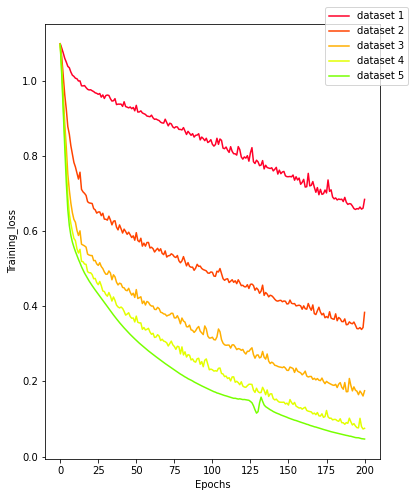

In [21]:
cm = plt.get_cmap('gist_rainbow')
fig = plt.figure(figsize=(6,8))
for i,j in enumerate(train_loss_all):
   plt.plot(j,label ="dataset "+str(i+1),color = cm(i*20))
plt.xlabel("Epochs")
plt.ylabel("Training_loss")

plt.legend(bbox_to_anchor=(1.1, 1.05))

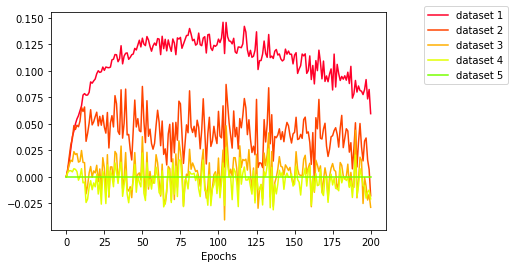

In [22]:
for i in range(len(train_loss_all)):
    temp = np.array(train_loss_all[i]) - np.array(train_loss_alpha_h_all[i])  
    plt.plot(temp,label ="dataset "+str(i+1),color = cm(i*20))
    plt.xlabel("Epochs")
    #plt.ylabel("Training_loss")
    plt.legend(bbox_to_anchor=(1.1, 1.05))